In [12]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE

# Improve quality of figures
%config InlineBackend.figure_format = 'retina'

In [13]:
# Data
df = pd.read_csv('car_df.csv')

# Transform NaN values by -1
df = df.fillna(-1)
# Type Int for Prev_Claim1
df['Prev_Claim1'] = df['Prev_Claim1'].astype(int)

df.head()

,NClaims1,Prev_Claim1,year,gender,Age_client,age_of_car_M,Car_power_M,Car_2ndDriver_M,num_policiesC,metro_code,Policy_PaymentMethodA,Client_Seniority,Retention
0,0,-1,1,1,84,13,90.0,0,1,0,0,16.963723,1
1,0,-1,1,1,83,0,177.0,0,1,0,1,16.796715,1
2,0,-1,1,1,85,0,163.0,0,1,0,1,18.603696,1
3,0,-1,1,1,85,0,90.0,0,1,0,1,20.484600,1
4,0,-1,1,1,82,20,115.0,0,1,0,1,7.901437,1


### Recall: Variables
- "year": the year of observation, ranging from 1 to 5 (2010 to 2014).
- "gender": a binary variable with 1 = male and 0 = female.
- "Age_client": the age of the customer in years.
- "age_of_car_M": the number of years since the customer bought the vehicle.
- "Car_power_M": the power of the vehicle.
- "Car_2ndDriver_M": a binary variable with 1 indicating that a second occasional driver uses the vehicle, and 0 otherwise.
- "num_policiesC": the total number of policies held by the customer in the insurance company.
- "metro_code": a binary variable with 1 indicating urban or metropolitan and 0 indicating rural.
- "Policy_PaymentMethodA": a binary variable with 1 indicating annual payment and 0 indicating monthly payment in the motor policy.
- "Client_Seniority": the number of years that the customer has been in the company.
- "Retention": a binary variable with 1 indicating that the policy is renewed and 0 indicating that it is not renewed.
- "NClaims1": the number of claims in the motor insurance policy for the corresponding year.
- "Prev_Claim1": 1 indicating that the customer had a claim in the motor insurance policy in the previous year and 0 if not and -1 if first year.
    
$\textbf{WARNING}$: All monetary units are expressed in Euros. Only claims at fault are considered in the motor insurance policy.

### Goal: predict the variable "NClaims1" (Car)
#### Models: Linear Regression GLM, Logistic Regression, MLP
1. GLM
2. Logistic Regression
3. MLP
4. AdaBoost
5. Random Forest

##### POUR CHOISIR LES PARAMETRES DES MODELES OPTIMAUX POUR CHAQUE MODEL, ON UTILISE GRIDSEARCHCV

In [14]:
# Train/Test Split
# The target variable is "NClaims1"
from sklearn.model_selection import train_test_split

X = df.drop('NClaims1', axis=1)
y = df['NClaims1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Selected Features:
Index(['Prev_Claim1', 'year', 'Age_client', 'Car_2ndDriver_M', 'Retention'], dtype='object')
Min: 0.008136346609544187
Max: 0.11769584323903688
Count: 14
[[34940  1049]
 [  815    77]]
True Negatives: 94.73712751823432
False Positives: 2.8442829641278706
False Negatives: 2.2098099292318536
True Positives: 0.2087795884059543
Metric: 89.89181421328055


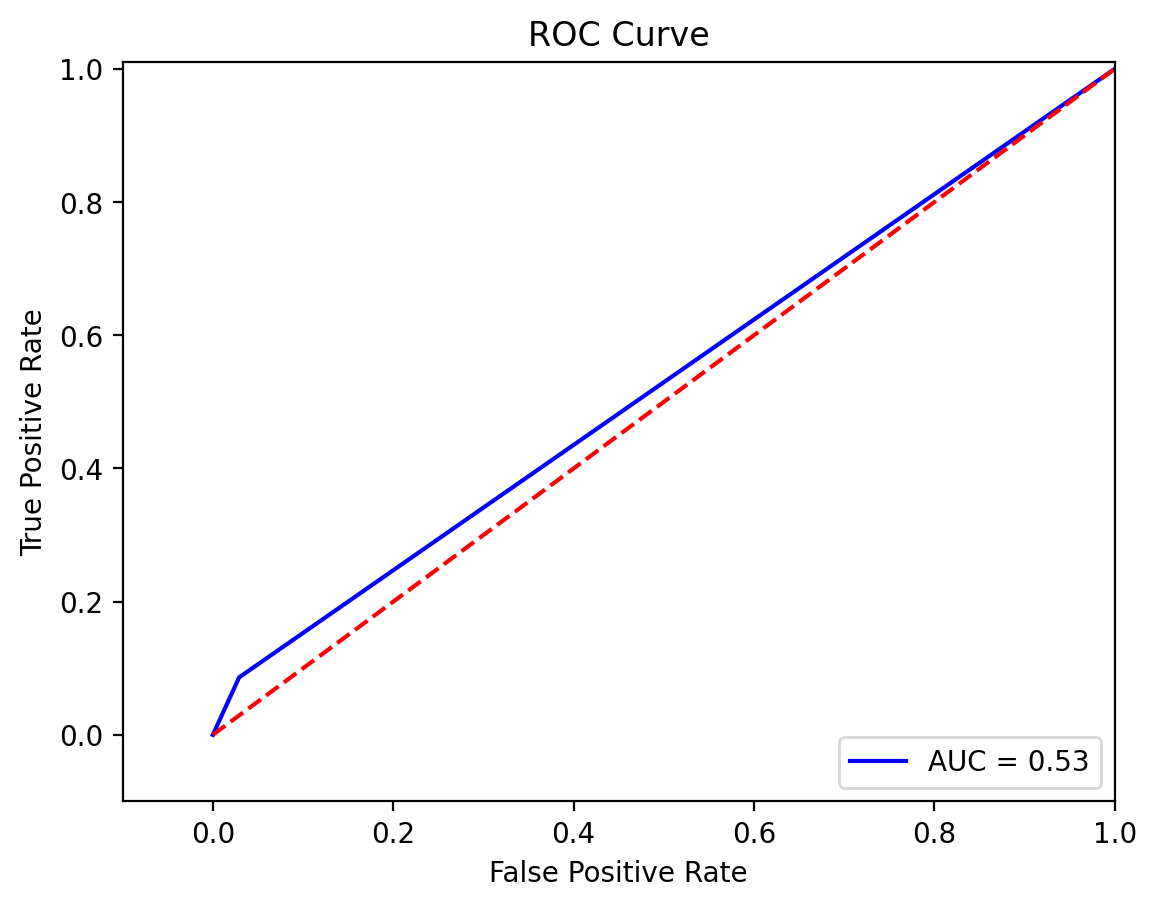

MAE: 0.05054092893359725
MSE: 0.05054092893359725
RMSE: 0.22481309778035008


In [15]:
# Model 1.1: GLM (Tweedie)
from sklearn.linear_model import TweedieRegressor

tweedie_model = TweedieRegressor(power=1, alpha=0.01, link='log') 
# alpha is modified to 0.01 WARNING: 0.5 normally   

tweedie_model = RFE(tweedie_model, n_features_to_select=5)

tweedie_model.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[tweedie_model.support_]

print("Selected Features:")
print(selected_features)

# Predictions
predictions = tweedie_model.predict(X_test)

# min and max values
print('Min:', predictions.min())
print('Max:', predictions.max())

# Count the value above x
print('Count:', np.count_nonzero(predictions > 0.081))

# Force the values above x to 1 and the rest to 0
predictions = np.where(predictions > 0.05, 1, 0)

# True and False Positives and Negatives
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

# Get the rates of True and False Positives and Negatives
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

# Print the rates as a percentage
print('True Negatives:', tn / len(y_test) * 100)
print('False Positives:', fp / len(y_test) * 100)
print('False Negatives:', fn / len(y_test) * 100)
print('True Positives:', tp / len(y_test) * 100)

# Create a good metric for the model using the rates puting more weight on the False Negatives
metric = tn / len(y_test) * 100 + tp / len(y_test) * 100 - fp / len(y_test) * 100 - fn / len(y_test) * 100
print('Metric:', metric)

# Roc Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predictions)

roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

### COMMENTS WARNING:
In your code, you are forcing the predicted values to be either 0 or 1 by applying a threshold (0.081 in this case). This approach is known as thresholding and can be a reasonable choice depending on the specific requirements of your problem.

However, it's important to consider the implications of thresholding and its impact on the performance of your model. Here are a few points to keep in mind:

- Loss of information: By thresholding the predicted values, you are discarding the actual predicted probabilities, reducing the granularity of the predictions. This loss of information may affect the model's ability to capture subtle differences between samples and can lead to suboptimal performance.
- Threshold selection: Choosing an appropriate threshold is crucial. A threshold that is too high may result in too few positive predictions (claims), leading to high false negatives (missed claims). Conversely, a threshold that is too low may increase false positives (false alarms). You should carefully select the threshold based on the trade-off between false positives and false negatives that is acceptable in your specific context.
- Imbalance consideration: In your original question, you mentioned that you have an imbalanced dataset. Thresholding may further amplify the impact of the class imbalance, especially if the threshold is chosen without considering the class distribution. It's important to evaluate the performance of the model using appropriate metrics, such as precision, recall, F1-score, or the ROC curve, to account for the imbalance.

### ALTENATIVES:
If you want to explore alternative methods for dealing with the class imbalance and obtaining better predictions, here are a few approaches to consider:

- Probability calibration: Instead of thresholding, you can calibrate the predicted probabilities using techniques such as Platt scaling or isotonic regression. These methods can adjust the predicted probabilities to better match the true class distribution and improve the reliability of the probabilities.
- Sampling techniques: As mentioned earlier, you can explore resampling techniques like oversampling the minority class or undersampling the majority class to create a more balanced training set. This can help the model learn from both classes more effectively.
- Cost-sensitive learning: You can assign different misclassification costs to the positive and negative classes during training. This approach allows the model to prioritize minimizing the misclassification of the minority class (claims) by penalizing false negatives more than false positives.
- Ensemble methods: Ensemble methods, such as bagging or boosting, can be effective in handling imbalanced datasets. Techniques like Random Forest or Gradient Boosting can combine multiple models to improve predictive performance by giving more attention to the minority class.

Remember that the choice of method depends on your specific dataset, problem, and the trade-offs you are willing to make. Experimentation and thorough evaluation are key to finding the best approach for your particular case.

In [16]:
# Model 1.2: GLM improved with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 2, 5, 10],
                'link': ['auto', 'log', 'identity', 'sqrt']}
tweedie_model = TweedieRegressor(power=1, alpha=0.01, link='log')

grid = GridSearchCV(tweedie_model, param_grid, refit=True, verbose=0)

grid.fit(X_train, y_train)

# Print the best parameters
print(grid.best_params_)

{'alpha': 0.01, 'link': 'auto'}


In [17]:
# Predictions
predictions = grid.predict(X_test)
# min and max values
print('Min:', predictions.min())
print('Max:', predictions.max())

# Count the value above x
print('Count:', np.count_nonzero(predictions > 0.071))

# Force the values above x to 1 and the rest to 0
predictions = np.where(predictions > 0.071, 1, 0)

# True and False Positives and Negatives
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

Min: 0.006367155244184624
Max: 0.11899931074674512
Count: 135
[[35864   125]
 [  882    10]]


Removed Features:
Index(['age_of_car_M', 'Car_power_M'], dtype='object')
Selected Features:
Index(['Prev_Claim1', 'year', 'gender', 'Age_client', 'Car_2ndDriver_M',
       'num_policiesC', 'metro_code', 'Policy_PaymentMethodA',
       'Client_Seniority', 'Retention'],
      dtype='object')
0
[[35989     0]
 [  892     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35989
           1       0.00      0.00      0.00       892

    accuracy                           0.98     36881
   macro avg       0.49      0.50      0.49     36881
weighted avg       0.95      0.98      0.96     36881

Accuracy:  0.975814104823622
F2 Score: 0.0


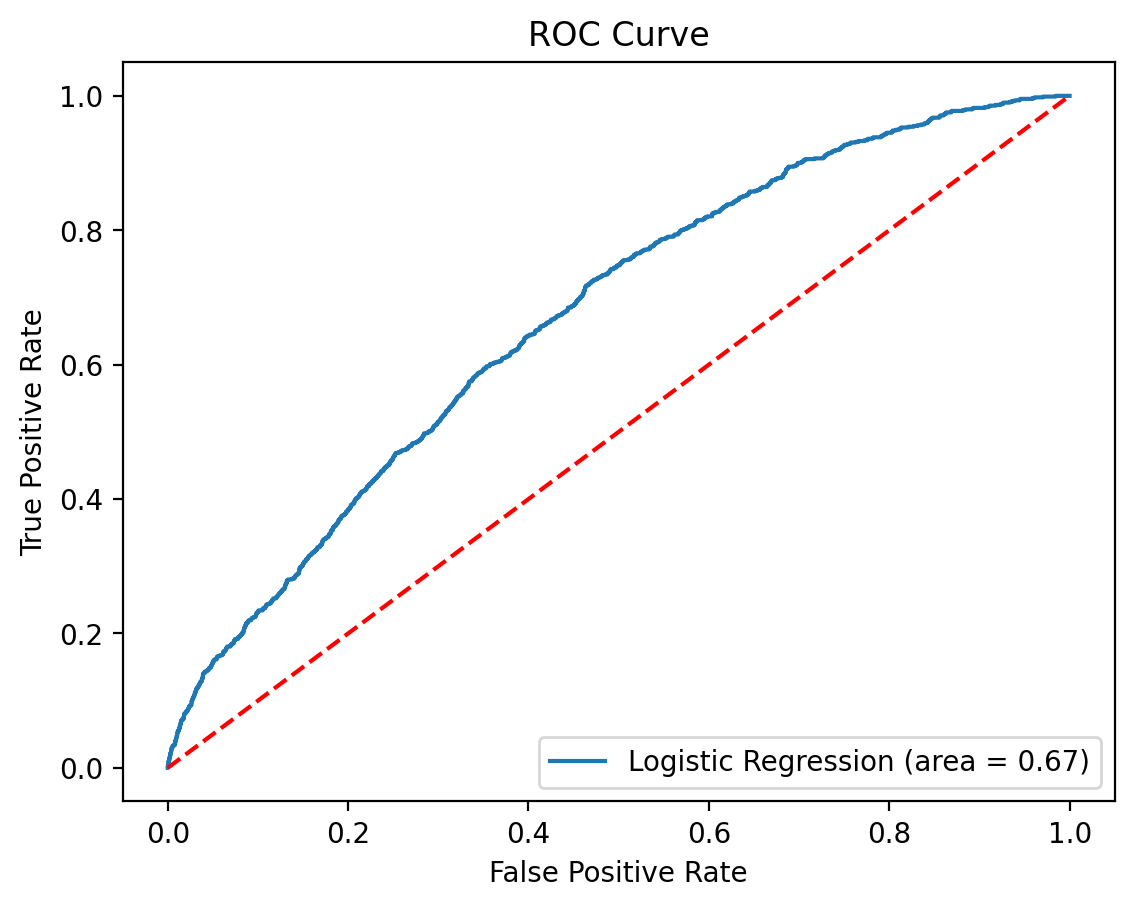

AUC: 0.6704666516811876


In [24]:
# Model 2: Logistic Regression
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()

# Feature Selection with RFE
# Find the best n for RFE
from sklearn.feature_selection import RFECV

log_model = RFECV(estimator=log_model, step=1, cv=5, scoring='roc_auc')

#log_model = RFE(log_model, n_features_to_select=5)

log_model.fit(X_train, y_train)

# Print the removed features
removed_features = X.columns[~log_model.support_]

print("Removed Features:")
print(removed_features)


selected_features = X.columns[log_model.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)

# Predictions
predictions = log_model.predict(X_test)
print(max(predictions))


# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy: ",log_model.score(X_test, y_test))

# F2 Score
from sklearn.metrics import fbeta_score

print('F2 Score:', fbeta_score(y_test, predictions, beta=10))

# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = log_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_scores[:,1]))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print('AUC:', roc_auc_score(y_test, y_scores[:,1]))

0
[[35989     0]
 [  892     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35989
           1       0.00      0.00      0.00       892

    accuracy                           0.98     36881
   macro avg       0.49      0.50      0.49     36881
weighted avg       0.95      0.98      0.96     36881

Accuracy:  0.6661181434360341


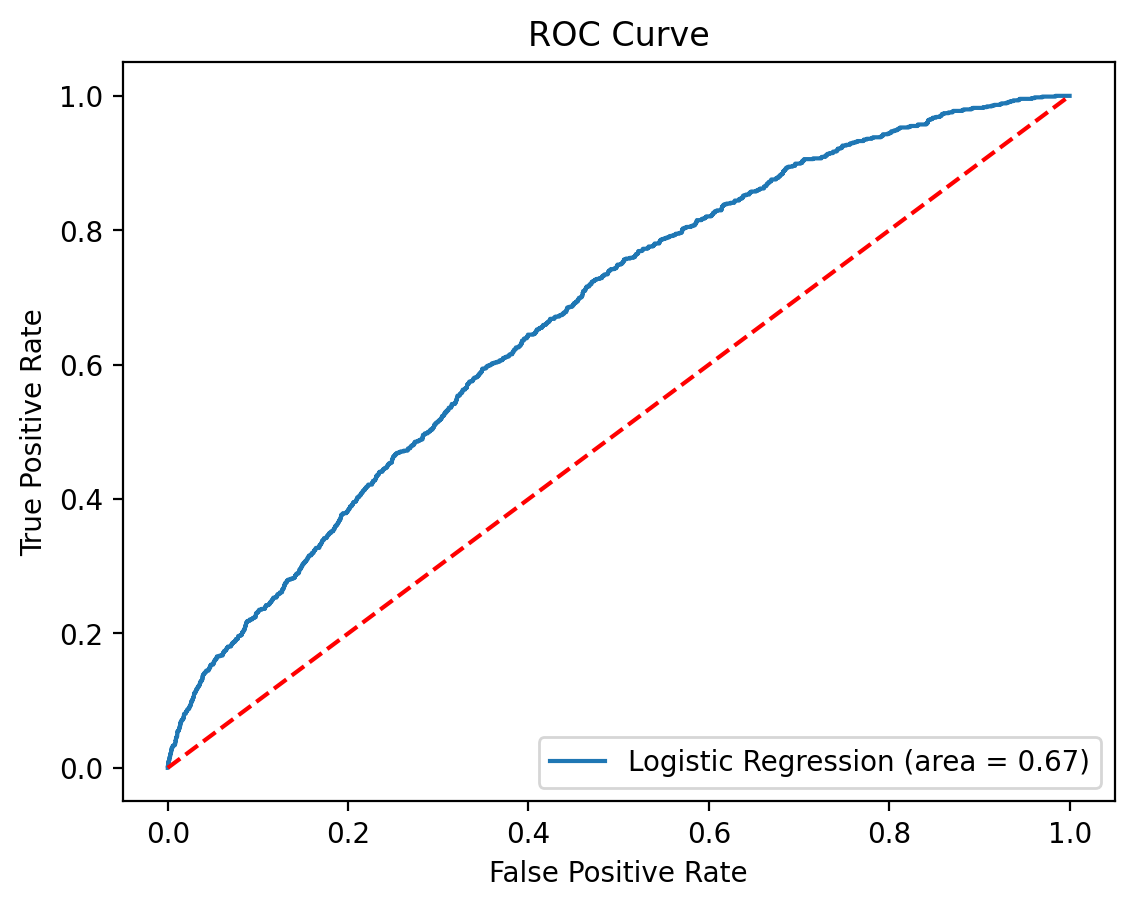

AUC: 0.6705865344754695


In [19]:
# Improve the Logistic Regression Model using GridSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l2']}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=0, scoring='roc_auc')
grid.fit(X_train, y_train)

# Predictions
grid_predictions = grid.predict(X_test)

print(max(grid_predictions))

# Evaluation
print(confusion_matrix(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))
# Print best score "the best score achieved during the GridSearchCV is:", grid.best_score_
print("Accuracy: ", grid.best_score_)


# ROC Curve and AUC
y_scores = grid.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_scores[:,1]))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print('AUC:', roc_auc_score(y_test, y_scores[:,1]))

[[35989     0]
 [  892     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35989
           1       0.00      0.00      0.00       892

    accuracy                           0.98     36881
   macro avg       0.49      0.50      0.49     36881
weighted avg       0.95      0.98      0.96     36881

Accuracy:  0.975814104823622


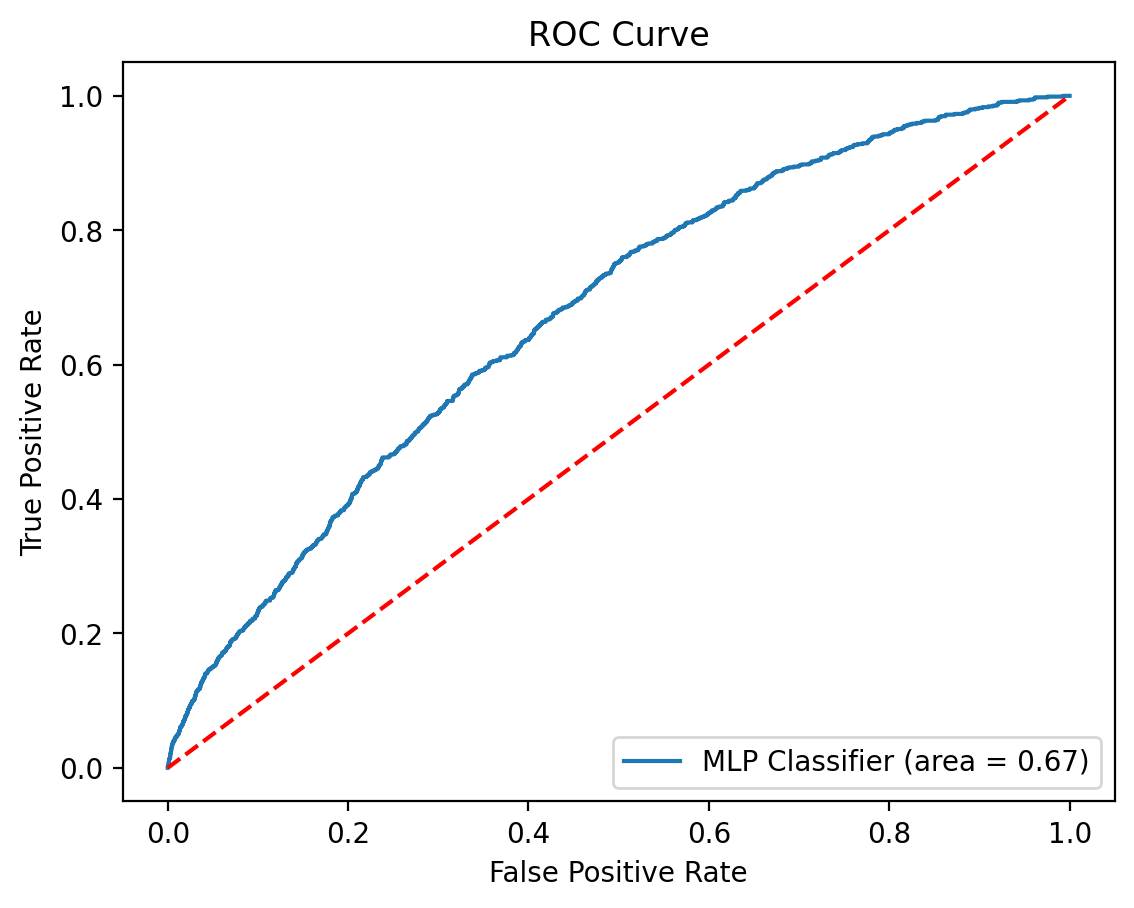

AUC: 0.6738378704903231


In [20]:
# Model 3: MLP Classifier
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(30,30,30), activation='logistic', solver='adam')

mlp_model.fit(X_train, y_train)

# Predictions
predictions = mlp_model.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy: ",mlp_model.score(X_test, y_test))

# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = mlp_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

plt.plot(fpr, tpr, label='MLP Classifier (area = %0.2f)' % roc_auc_score(y_test, y_scores[:,1]))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print('AUC:', roc_auc_score(y_test, y_scores[:,1]))

[[35989     0]
 [  892     0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35989
           1       0.00      0.00      0.00       892

    accuracy                           0.98     36881
   macro avg       0.49      0.50      0.49     36881
weighted avg       0.95      0.98      0.96     36881

Accuracy:  0.975814104823622


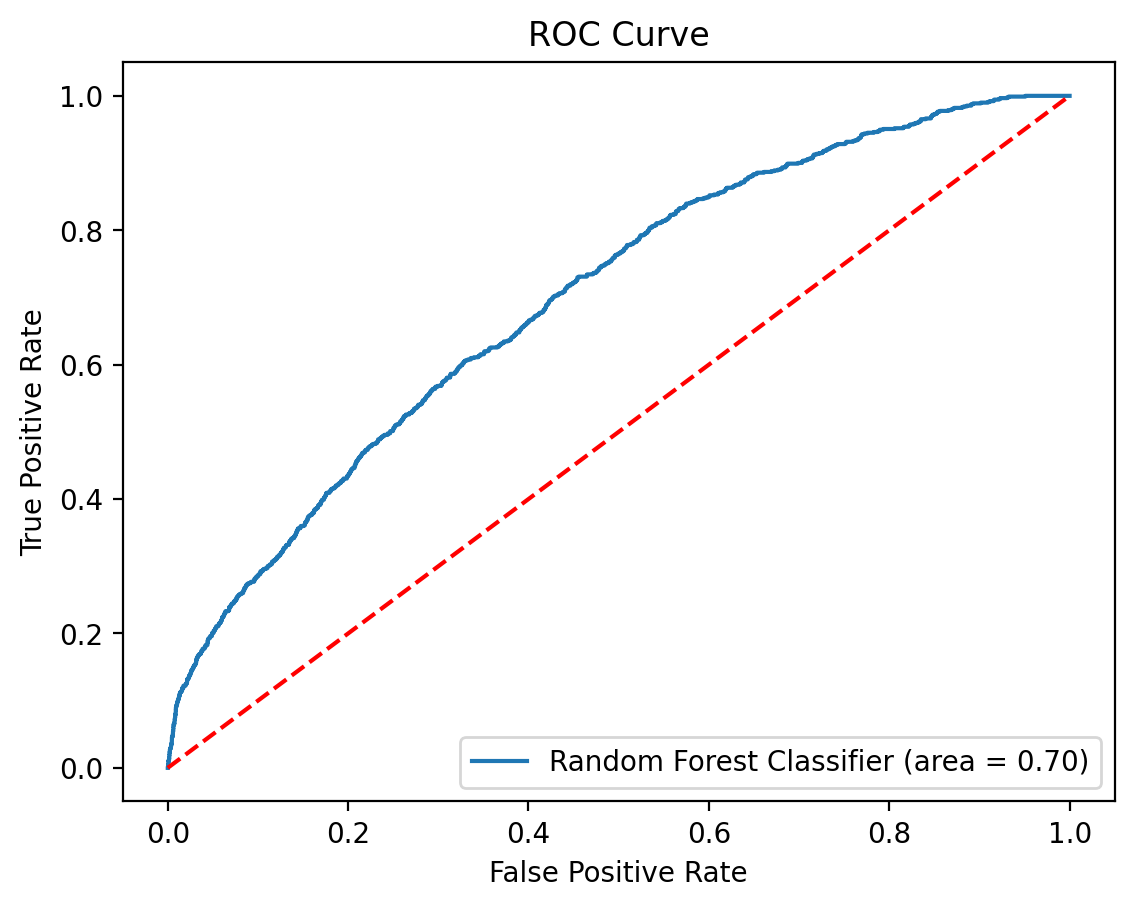

AUC: 0.6977021784309531


In [21]:
# Model 4: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1, max_features='sqrt', criterion='log_loss')

rfc_model.fit(X_train, y_train)

# Predictions
predictions = rfc_model.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("Accuracy: ",rfc_model.score(X_test, y_test))

# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = rfc_model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % roc_auc_score(y_test, y_scores[:,1]))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print('AUC:', roc_auc_score(y_test, y_scores[:,1]))